In [64]:
import csv
import random
import math
import matplotlib.pyplot as plt

In [65]:
def read_csv(file_name):
    with open(file_name, 'r') as file:
        reader = csv.reader(file)
        header = next(reader)
        data = []
        for row in reader:
            data.append([float(value) for value in row])
    return data

In [66]:
def read_csv1(file_name):
    with open(file_name, 'r') as file:
        reader = csv.reader(file)
        header = next(reader)
        data = []
        true_labels = []
        for row in reader:
            true_labels.append(int(row[0]))
            features = [float(value) for value in row[2:]]
            data.append(features)
    return data, true_labels

In [67]:
def euclidean_distance(p1, p2):
    return math.sqrt(sum((x - y) ** 2 for x, y in zip(p1, p2)))

In [68]:
def initialize_centroids(data, k):
    return random.sample(data, k)

In [69]:
def assign_clusters(data, centroids):
    clusters = [[] for _ in centroids]
    for point in data:
        distances = [euclidean_distance(point, centroid) for centroid in centroids]
        closest_centroid_index = distances.index(min(distances))
        clusters[closest_centroid_index].append(point)
    return clusters

In [70]:
def update_centroids(clusters):
    new_centroids = []
    for cluster in clusters:
        if cluster:
            new_centroid = [sum(dim) / len(cluster) for dim in zip(*cluster)]
            new_centroids.append(new_centroid)
        else:
            new_centroids.append(random.choice(cluster))
    return new_centroids

In [71]:
def kmeans(data, k, m_iterations=80):
    centroids = initialize_centroids(data, k)
    for _ in range(m_iterations):
        clusters = assign_clusters(data, centroids)
        new_centroids = update_centroids(clusters)
        if new_centroids == centroids:
            break
        centroids = new_centroids
    return centroids, clusters

In [72]:
def calculate_inertia(data, centroids, clusters):
    inertia = 0
    for i, cluster in enumerate(clusters):
        for point in cluster:
            inertia += euclidean_distance(point, centroids[i]) ** 2
    return inertia

In [73]:
def elbow_method(data, max_k=10):
    inertias = []
    for k in range(1, max_k + 1):
        centroids, clusters = kmeans(data, k)
        inertia = calculate_inertia(data, centroids, clusters)
        inertias.append(inertia)

    plt.plot(range(1, max_k + 1), inertias, marker='o')
    plt.title('Elbow Method For Optimal K')
    plt.xlabel('Number of Clusters (K)')
    plt.ylabel('Inertia')
    plt.show()

    inertia_diffs = [inertias[i] - inertias[i - 1] for i in range(1, len(inertias))]
    largest_drop_index = inertia_diffs.index(max(inertia_diffs)) + 1  # +1 to match actual k value
    return largest_drop_index, inertias

In [74]:
def silhouette_score(data, labels):
    num_samples = len(data)
    unique_labels = set(labels)
    silhouette_scores = []

    for i in range(num_samples):
        point = data[i]
        cluster_label = labels[i]

        same_cluster_points = [data[j] for j in range(num_samples) if labels[j] == cluster_label and j != i]
        a_i = sum(euclidean_distance(point, other_point) for other_point in same_cluster_points) / len(same_cluster_points)

        nearest_cluster_distances = []
        for label in unique_labels:
            if label != cluster_label:
                other_cluster_points = [data[j] for j in range(num_samples) if labels[j] == label]
                b_i = sum(euclidean_distance(point, other_point) for other_point in other_cluster_points) / len(other_cluster_points)
                nearest_cluster_distances.append(b_i)

        b_i = min(nearest_cluster_distances)

        silhouette_i = (b_i - a_i) / max(a_i, b_i)
        silhouette_scores.append(silhouette_i)

    return sum(silhouette_scores) / len(silhouette_scores)


In [75]:
def davies_bouldin_index(data, labels, centroids):
    from collections import defaultdict

    cluster_dict = defaultdict(list)
    for point, label in zip(data, labels):
        cluster_dict[label].append(point)

    S = []
    for i in range(len(centroids)):
        points_i = cluster_dict[i]
        if points_i:
            s_i = sum(euclidean_distance(p, centroids[i]) for p in points_i) / len(points_i)
            S.append(s_i)
        else:
            S.append(0)

    db_indexes = []
    for i in range(len(centroids)):
        max_rij = -float('inf')
        for j in range(len(centroids)):
            if i != j:
                M_ij = euclidean_distance(centroids[i], centroids[j])
                if M_ij != 0:
                    R_ij = (S[i] + S[j]) / M_ij
                    max_rij = max(max_rij, R_ij)
        db_indexes.append(max_rij)

    return sum(db_indexes) / len(db_indexes)

In [76]:
def calinski_harabasz_index(data, labels, centroids):
    from collections import defaultdict

    n_samples = len(data)
    k = len(centroids)
    overall_mean = [sum(dim) / n_samples for dim in zip(*data)]

    cluster_dict = defaultdict(list)
    for point, label in zip(data, labels):
        cluster_dict[label].append(point)

    B = 0
    for i, centroid in enumerate(centroids):
        n_i = len(cluster_dict[i])
        dist = euclidean_distance(centroid, overall_mean)
        B += n_i * dist ** 2

    W = 0
    for i, points in cluster_dict.items():
        for point in points:
            W += euclidean_distance(point, centroids[i]) ** 2

    if W == 0 or k == 1:
        return 0

    return (B / (k - 1)) / (W / (n_samples - k))

In [77]:
def adjusted_rand_score(true_labels, predicted_labels):
    from collections import Counter
    from math import comb

    n = len(true_labels)
    if n != len(predicted_labels):
        raise ValueError("Label lists must be of same length.")

    label_pairs = list(zip(true_labels, predicted_labels))
    contingency = {}
    for t, p in label_pairs:
        contingency[(t, p)] = contingency.get((t, p), 0) + 1

    true_label_counts = Counter(true_labels)
    pred_label_counts = Counter(predicted_labels)

    sum_comb_c = sum(comb(count, 2) for count in contingency.values())
    sum_comb_true = sum(comb(count, 2) for count in true_label_counts.values())
    sum_comb_pred = sum(comb(count, 2) for count in pred_label_counts.values())

    expected_index = sum_comb_true * sum_comb_pred / comb(n, 2)
    max_index = 0.5 * (sum_comb_true + sum_comb_pred)
    ari = (sum_comb_c - expected_index) / (max_index - expected_index) if max_index != expected_index else 1.0

    return ari

LAB_VEHICLE:
------------------------


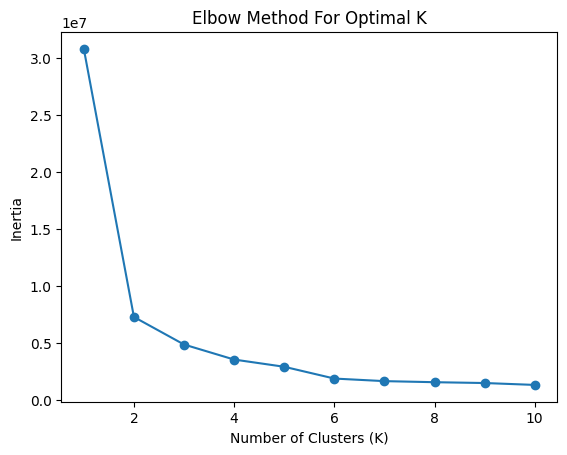

Silhouette Score for K=2: -0.007213821537093545
Davies-Bouldin Index for K=2: 1.283991443130976
Calinski-Harabasz Index for K=2: 342.0013796162399
Centroids for K=2:
Centroid 1: [102.88888888888889, 51.738351254480285, 100.81362007168458, 201.20071684587813, 62.4910394265233, 9.508960573476703, 210.831541218638, 31.60931899641577, 23.8673835125448, 162.99641577060933, 225.584229390681, 664.4444444444445, 207.78494623655914, 71.65591397849462, 7.129032258064516, 15.010752688172044, 189.1720430107527, 197.08243727598565]
Centroid 2: [89.14638447971781, 41.47795414462081, 72.8747795414462, 153.06701940035273, 61.301587301587304, 8.10405643738977, 148.17636684303352, 45.52204585537919, 18.966490299823633, 140.61904761904762, 170.43915343915344, 329.4268077601411, 158.42504409171076, 72.85890652557319, 6.00705467372134, 11.412698412698413, 188.8148148148148, 194.91887125220458]

Cluster assignments for K=2:
Cluster 1 (279 points): [[104.0, 50.0, 106.0, 209.0, 66.0, 10.0, 207.0, 32.0, 23.0, 

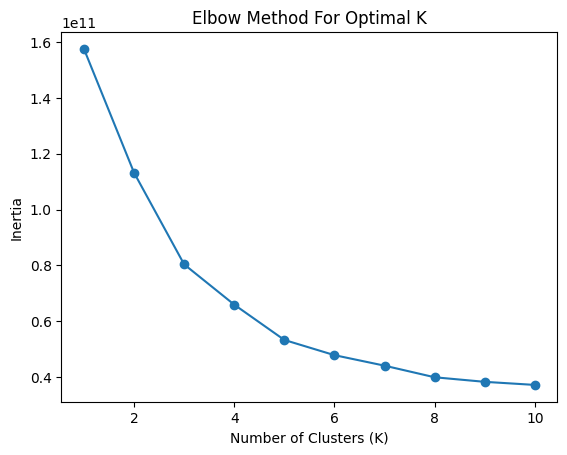

Silhouette Score for K=4: -0.06519032131822748
Davies-Bouldin Index for K=4: 1.912499149207735
Calinski-Harabasz Index for K=4: 53.77129057649277
Adjusted Rand Index for K=4: 0.05409967262323665
Centroids for K=4:
Centroid 1: [8149.836734693878, 18715.85714285714, 27756.591836734693, 2034.7142857142858, 12523.020408163266, 2282.1428571428573]
Centroid 2: [47543.192307692305, 7026.884615384615, 6255.576923076923, 9412.653846153846, 943.1153846153846, 4250.153846153846]
Centroid 3: [5411.675889328063, 4132.624505928854, 5573.387351778656, 2263.4664031620555, 1990.5256916996047, 1055.1699604743083]
Centroid 4: [20317.071428571428, 3616.3125, 5051.580357142857, 3880.026785714286, 1125.9375, 1621.9285714285713]

Cluster assignments for K=4:
Cluster 1 (49 points): [[6006.0, 11093.0, 18881.0, 1159.0, 7425.0, 2098.0], [26373.0, 36423.0, 22019.0, 5154.0, 4337.0, 16523.0], [4113.0, 20484.0, 25957.0, 1158.0, 8604.0, 5206.0]]...
Cluster 2 (26 points): [[43088.0, 2100.0, 2609.0, 1200.0, 1107.0, 823

In [78]:
def main():
    #Given dataset
    print("LAB_VEHICLE:")
    print("------------------------")
    file_name = "/content/lab_vehicle.csv"
    data = read_csv(file_name)

    inertias = elbow_method(data, max_k=10)

    k = 2
    centroids, clusters = kmeans(data, k)

    labels = [cluster_idx for cluster_idx, cluster in enumerate(clusters) for _ in cluster]

    score = silhouette_score(data, labels)
    print(f"Silhouette Score for K={k}: {score}")

    dbi = davies_bouldin_index(data, labels, centroids)
    print(f"Davies-Bouldin Index for K={k}: {dbi}")

    chi = calinski_harabasz_index(data, labels, centroids)
    print(f"Calinski-Harabasz Index for K={k}: {chi}")

    print(f"Centroids for K={k}:")
    for i, centroid in enumerate(centroids):
        print(f"Centroid {i + 1}: {centroid}")

    print(f"\nCluster assignments for K={k}:")
    for i, cluster in enumerate(clusters):
        print(f"Cluster {i + 1} ({len(cluster)} points): {cluster[:3]}...")

    #Own Dataset
    print("WHOLESALE CUSTOMER DATA:")
    print("-------------------------")
    file_name = "/content/Wholesale customers data.csv"
    data, true_labels = read_csv1(file_name)

    inertias = elbow_method(data, max_k=10)

    k = 4
    centroids, clusters = kmeans(data, k)

    labels = [cluster_idx for cluster_idx, cluster in enumerate(clusters) for _ in cluster]

    score = silhouette_score(data, labels)
    print(f"Silhouette Score for K={k}: {score}")

    dbi = davies_bouldin_index(data, labels, centroids)
    print(f"Davies-Bouldin Index for K={k}: {dbi}")

    chi = calinski_harabasz_index(data, labels, centroids)
    print(f"Calinski-Harabasz Index for K={k}: {chi}")

    ari = adjusted_rand_score(true_labels, labels)
    print(f"Adjusted Rand Index for K={k}: {ari}")

    print(f"Centroids for K={k}:")
    for i, centroid in enumerate(centroids):
        print(f"Centroid {i + 1}: {centroid}")

    print(f"\nCluster assignments for K={k}:")
    for i, cluster in enumerate(clusters):
        print(f"Cluster {i + 1} ({len(cluster)} points): {cluster[:3]}...")


if __name__ == "__main__":
    main()